In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

df = pd.read_csv('Train_SU63ISt.csv')#,parse_dates=['Datetime'], index_col='date')
submission = pd.read_csv('sample_submission_LSeus50.csv')


# Extract the trend, the seasonality and the noise from the time serie

In [15]:
result_mul = seasonal_decompose(df['Count'], model='multiplicative', extrapolate_trend='freq', period=168)

In [16]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed['product'] = (df_reconstructed['seas']*df_reconstructed['trend']*df_reconstructed['resid'])

# Forecasting model

## Forecasting the trend

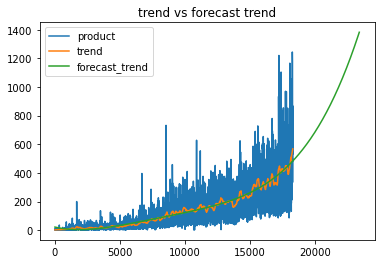

In [17]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

N=len(submission)
def trend_forecasting(model_trend=LinearRegression(),N_forecast = N ):
    model = make_pipeline(PolynomialFeatures(degree=4), StandardScaler(), model_trend )
    y = df_reconstructed['trend']
    X = [[i] for i in range(len(y))]
    model.fit(X,y)
    X_pred = [[i] for i in range(len(y) + N_forecast)]
    y_pred = model.predict(X_pred)
    return y_pred

### get the trend from the forecasting function
y_pred = trend_forecasting()
df_forecast = pd.DataFrame()
df_forecast['forecast_trend'] = y_pred 

###change datatimeindex to rangeindex
df_reconstructed.index = pd.RangeIndex(start=0, stop=len(df_reconstructed['trend']), step=1)
df_forecast.index = pd.RangeIndex(start=0, stop=len(df_reconstructed['trend'])+N, step=1)

### plot the forecast trend ###
plt.figure()
plt.title('trend vs forecast trend')
df_reconstructed['product'].plot()
df_reconstructed['trend'].plot()
df_forecast['forecast_trend'].plot()
plt.legend()
plt.show()

## Forecasting the seasonality

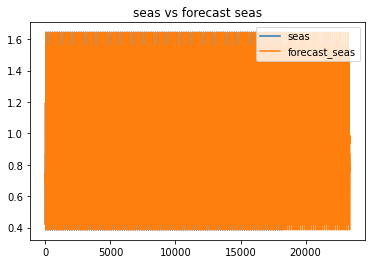

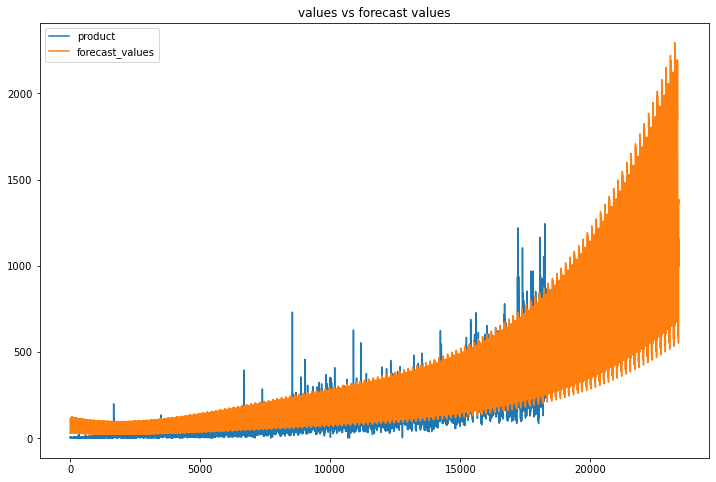

In [18]:
#forecasting seasonality
from sklearn.ensemble import RandomForestRegressor
def seas_forecasting(model_seas=RandomForestRegressor(n_estimators=100), N_forecast=N, period=168):
    model = make_pipeline(StandardScaler(), model_seas)
    y = df_reconstructed['seas']
    X = [[i%period] for i in range(len(y))]
    model.fit(X,y)
    X_pred = [[i%period] for i in range(len(y) + N_forecast)]
    y_pred = model.predict(X_pred)
    return y_pred

### get the seasonality from the forecasting function
y_pred = seas_forecasting()

df_forecast['forecast_seas'] = y_pred


###reconstruct a signal
df_forecast['forecast_values'] = df_forecast['forecast_trend']*df_forecast['forecast_seas']

### plot the forecast seasonality ###
plt.figure()
plt.title('seas vs forecast seas')
df_reconstructed['seas'].plot()
df_forecast['forecast_seas'].plot()
plt.legend()
plt.show()


###increase the values where seasonality is hight 
for i in range(len(y_pred)):  #increase the highest values
    if df_forecast['forecast_seas'][i] > 1:
        df_forecast['forecast_values'][i] = df_forecast['forecast_values'][i]+91
    else:
        df_forecast['forecast_values'][i] = df_forecast['forecast_values'][i]+22


### plot the forecast without noise 
plt.figure(figsize=(12,8))
plt.title('values vs forecast values')
df_reconstructed['product'].plot()
df_forecast['forecast_values'].plot()
plt.legend()
plt.show()

# Submission 

In [19]:
submission['Count'] = list(df_forecast[-N:]['forecast_values'])


In [20]:
submission.to_csv('sub_test.csv', index=False)
